# Самостоятельная работа 4: Деревья и KNN. Продвинутый вариант

## 1. Загружаем предобработанные данные из Самостоятельной работы 2: 

In [13]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"X:\TUSUR_LEARNING\HW_4\df.csv")
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
# датафрейм должен содержать уникальные записи по order_id, order_id затем удаляем
df['products'] = df[['order_id','product_name']].groupby(['order_id'])['product_name'].transform(lambda x: ','.join(x))
df.drop('product_name', axis=1, inplace=True)

df2 = df.drop_duplicates(keep='last').reset_index(drop=True)
df2.drop('order_id', axis=1, inplace=True)
df = df2
df

,store_id,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id,store_name,region_name,items_count,order_price,prepared_on_time,products
0,5014,45.5040,2205,2024-09-05 15:25:25.000000000,2024-09-05 15:25:33.000000000,15.0,2024-09-05 15:32:00.000000000,05-09-2024 16:00:00,683,F,KFC на Пушкинской,Sovetsky District,2,30.49,1,"Nachos,Curry"
1,3856,30.3360,1368,2024-09-05 15:25:12.000000000,2024-09-05 15:25:19.000000000,10.0,2024-09-05 15:35:50.000000000,05-09-2024 16:03:50,683,F,NaN,Sovetsky District,2,240.78,1,"Soup,Salad"
2,10825,43.6080,459,2024-09-05 15:23:32.000000000,2024-09-05 15:23:44.000000000,20.0,2024-09-05 15:38:38.000000000,05-09-2024 16:06:38,683,F,NaN,Sovetsky District,1,85.99,1,Sushi
3,5640,32.8640,2611,2024-09-05 15:19:00.000000000,2024-09-05 15:19:05.000000000,20.0,2024-09-05 15:35:25.000000000,05-09-2024 16:03:25,709,F,NaN,Vostochny District,2,24.68,1,"Burrito,Wrap"
4,7283,11.0600,1041,2024-09-05 15:18:39.000000000,2024-09-05 15:21:03.271615914,15.0,2024-09-05 15:35:33.000000000,05-09-2024 16:03:33,707,F,NaN,Kirovsky District,1,14.02,1,Frittata
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7820,7557,50.1650,8046,2024-09-03 15:02:55.000000000,2024-09-03 15:03:01.000000000,35.0,2024-09-03 15:27:37.000000000,03-09-2024 15:55:37,683,F,NaN,Sovetsky District,5,277.28,1,"Jambalaya,Burrito,Curry,Porridge,Salad"
7821,4548,14.6150,2225,2024-09-03 15:01:55.000000000,2024-09-03 15:02:04.000000000,20.0,2024-09-03 15:17:18.000000000,03-09-2024 15:45:18,707,F,NaN,Kirovsky District,2,21.05,1,"Waffle,Tacos"
7822,7099,12.1976,3354,2024-09-03 15:02:21.000000000,2024-09-03 15:02:27.000000000,25.0,2024-09-03 15:27:40.000000000,03-09-2024 15:55:40,683,F,NaN,Sovetsky District,5,102.11,1,"Nachos,Dumplings,Potato,Cereal,Fruit Salad"
7823,4348,49.2960,2129,2024-09-03 15:01:24.000000000,2024-09-03 15:03:49.000000000,30.0,2024-09-03 15:20:34.000000000,03-09-2024 15:48:34,683,F,NaN,Sovetsky District,3,43.43,1,"Steak,Steak,Mozzarella Sticks"


## 2. Разбиение на признаки и целевую переменную:

Целевой переменной является prepared_on_time. Среди признаков есть признаки, напрямую влияющие на целевую переменную - order_start_prepare, planned_prep_time, order_ready.

In [14]:
label = df['prepared_on_time']
features = df.drop(columns={'prepared_on_time', 'status_id', 'store_name', 'products', 'region_name'})

# для дат преобразуем их в число наносекунд
features['order_start_prepare'] = pd.to_datetime(features['order_start_prepare'])
features['order_ready'] = pd.to_datetime(features['order_ready'])
features['order_pickup'] = pd.to_datetime(features['order_pickup'])
features['date_create'] = pd.to_datetime(features['date_create'])

features['order_start_prepare'] = features['order_start_prepare'].astype('int64') 
features['order_ready'] = features['order_ready'].astype('int64') 
features['order_pickup'] = features['order_pickup'].astype('int64') 
features['date_create'] = features['date_create'].astype('int64') 

features

,store_id,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,items_count,order_price
0,5014,45.5040,2205,1725549925000000000,1725549933000000000,15.0,1725550320000000000,1715270400000000000,683,2,30.49
1,3856,30.3360,1368,1725549912000000000,1725549919000000000,10.0,1725550550000000000,1715270630000000000,683,2,240.78
2,10825,43.6080,459,1725549812000000000,1725549824000000000,20.0,1725550718000000000,1715270798000000000,683,1,85.99
3,5640,32.8640,2611,1725549540000000000,1725549545000000000,20.0,1725550525000000000,1715270605000000000,709,2,24.68
4,7283,11.0600,1041,1725549519000000000,1725549663271615914,15.0,1725550533000000000,1715270613000000000,707,1,14.02
...,...,...,...,...,...,...,...,...,...,...,...
7820,7557,50.1650,8046,1725375775000000000,1725375781000000000,35.0,1725377257000000000,1709999737000000000,683,5,277.28
7821,4548,14.6150,2225,1725375715000000000,1725375724000000000,20.0,1725376638000000000,1709999118000000000,707,2,21.05
7822,7099,12.1976,3354,1725375741000000000,1725375747000000000,25.0,1725377260000000000,1709999740000000000,683,5,102.11
7823,4348,49.2960,2129,1725375684000000000,1725375829000000000,30.0,1725376834000000000,1709999314000000000,683,3,43.43


## 3. Разделение на обучение и тест

Сделаем разбиение на обучающую и тестовую выборку в соотношении 70/30

In [15]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

feat_train, feat_test, label_train, label_test = train_test_split(features, label, test_size = 0.3, random_state=42)


## 4. Исползуем GridSearchCV для нахождения лучших гиперпараметров

In [25]:
def tune(model, params: dict, train_x, train_y):
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy')

    grid.fit(train_x, train_y)
    best_model = grid.best_estimator_
    print(f"Лучшие гиперпараметры: {grid.best_params_}")

    print(f"Лучшая кросс-валидационная точность: {grid.best_score_:.4f}")

    return best_model


params = {
    'max_depth' : [2, 3, 5, 7],
    'min_samples_leaf' : [1, 2, 3, 5],
    'criterion' : ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

clf = DecisionTreeClassifier()
best_clf = tune(clf, params, feat_train, label_train)

Лучшие гиперпараметры: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
Лучшая кросс-валидационная точность: 0.8163


## 5. Визуализируем дерево и оценим важность признаков

tree accuracy: 0.8100511073253833


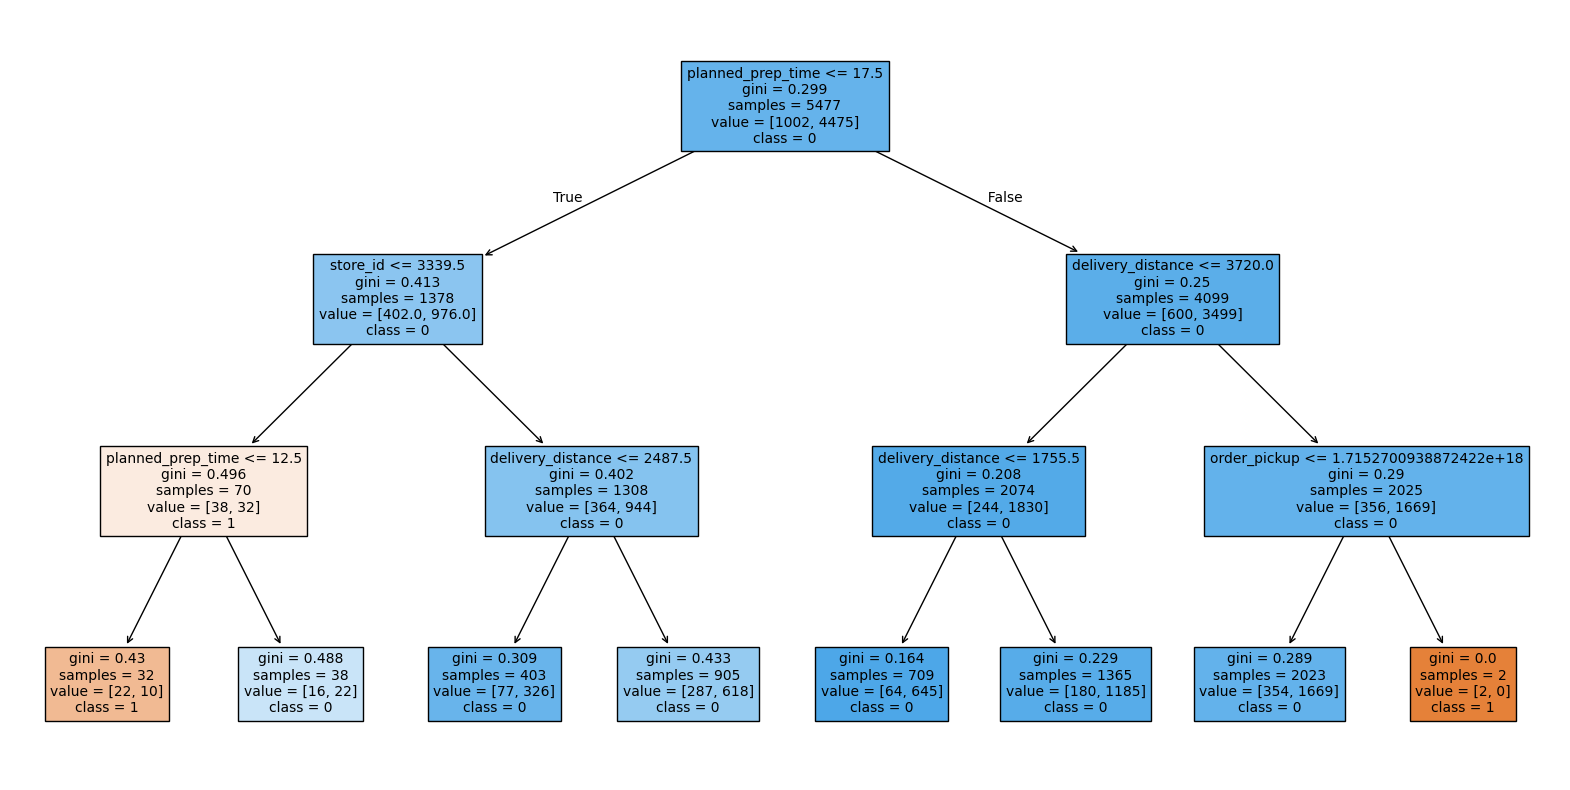

In [26]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(feat_train, label_train)

tree_pred_res = clf.predict(feat_test)
tree_accuracy = accuracy_score(label_test, tree_pred_res)
print(f'tree accuracy: {tree_accuracy}')

fn = features.columns.tolist()
cn = label.unique().astype(str).tolist()
fig = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    clf,
    feature_names=fn,
    class_names=cn,
    filled=True,
    fontsize=10
)

plt.show()

Оценим значимость параметров на основе feature_importances_

In [27]:
importance = clf.feature_importances_

for i, score in enumerate(importance):
    print(f"Feature {i}: {score}")

Feature 0: 0.12324909832584377
Feature 1: 0.0
Feature 2: 0.2306509704830184
Feature 3: 0.0
Feature 4: 0.0
Feature 5: 0.6100612578466101
Feature 6: 0.0
Feature 7: 0.03603867334452768
Feature 8: 0.0
Feature 9: 0.0
Feature 10: 0.0


## 6. Обучение дерева с наилучшими гиперпараметрами от GridSearchCV

tree accuracy: 0.8083475298126065


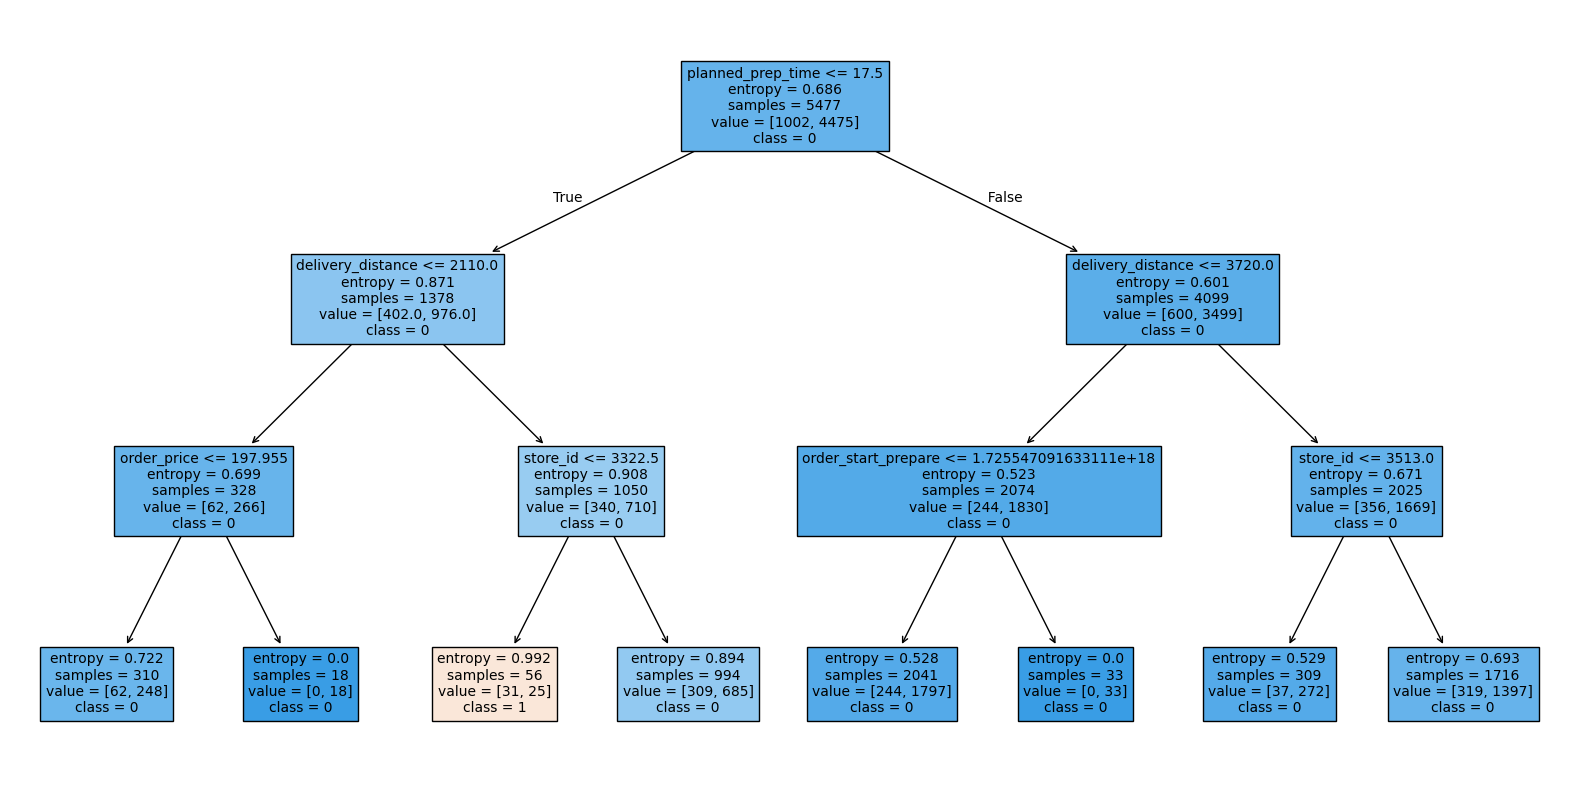

In [31]:
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    min_samples_leaf=2,
    class_weight=None
)
clf.fit(feat_train, label_train)

tree_pred_res = clf.predict(feat_test)
tree_accuracy = accuracy_score(label_test, tree_pred_res)
print(f'tree accuracy: {tree_accuracy}')

fn = features.columns.tolist()
cn = label.unique().astype(str).tolist()
fig = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    clf,
    feature_names=fn,
    class_names=cn,
    filled=True,
    fontsize=10
)

plt.show()

Теперь оценим качество классификации на тестовой выборке

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(label_test, tree_pred_res)
precision = precision_score(label_test, tree_pred_res, average='weighted')
recall = recall_score(label_test, tree_pred_res, average='weighted')
f1 = f1_score(label_test, tree_pred_res, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(label_test, tree_pred_res))

Accuracy: 0.8083
Precision: 0.7451
Recall: 0.8083
F1-Score: 0.7351

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.03      0.06       447
           1       0.81      0.99      0.89      1901

    accuracy                           0.81      2348
   macro avg       0.63      0.51      0.48      2348
weighted avg       0.75      0.81      0.74      2348



## 7. Выводы по метркикам

В данных наблюдается сильный дисбаланс классов (1901 объектов класса 1 и 447 объекта класса 0). Это видно по меткам Recall и F1-Score, где модель почти идеально классифицирует класс 1 (высокие значения Recall и F1 для класса 1), но плохо справляется с классом 0 (низкие значения для Precision, Recall, и F1-Score). Модель предпочитает классифицировать объекты как класс 1, потому что их гораздо больше в данных. Это вызывает проблему с классификацией объектов класса 0 (низкий Recall для класса 0). 

tree accuracy: 0.5221465076660988
Accuracy: 0.5221
Precision: 0.7301
Recall: 0.5221
F1-Score: 0.5717

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.62      0.33       447
           1       0.85      0.50      0.63      1901

    accuracy                           0.52      2348
   macro avg       0.54      0.56      0.48      2348
weighted avg       0.73      0.52      0.57      2348



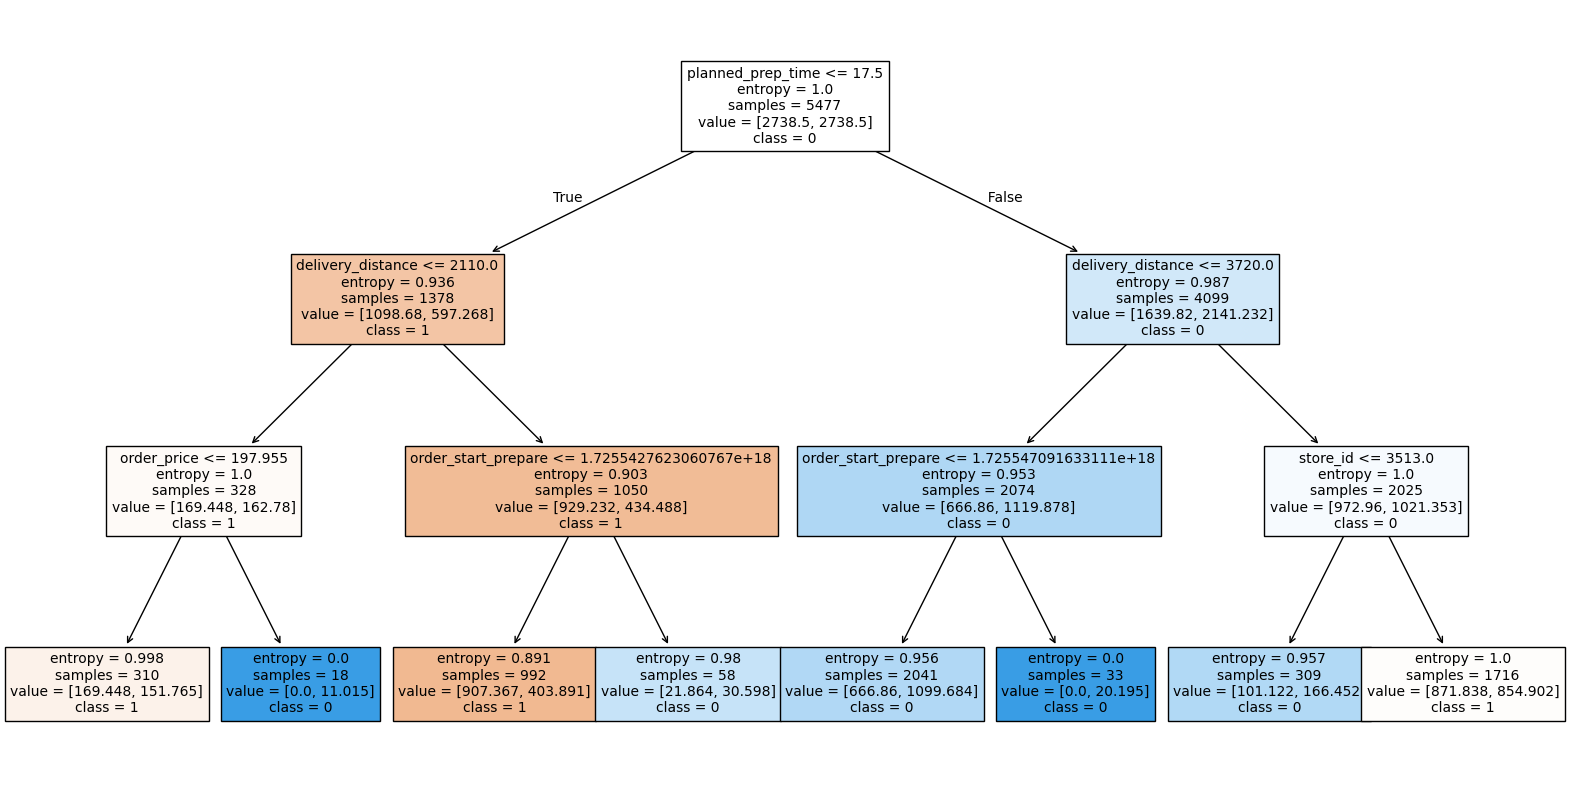

In [33]:
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    min_samples_leaf=2,
    class_weight='balanced'
)
clf.fit(feat_train, label_train)

tree_pred_res = clf.predict(feat_test)
tree_accuracy = accuracy_score(label_test, tree_pred_res)
print(f'tree accuracy: {tree_accuracy}')

fn = features.columns.tolist()
cn = label.unique().astype(str).tolist()
fig = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    clf,
    feature_names=fn,
    class_names=cn,
    filled=True,
    fontsize=10
)

accuracy = accuracy_score(label_test, tree_pred_res)
precision = precision_score(label_test, tree_pred_res, average='weighted')
recall = recall_score(label_test, tree_pred_res, average='weighted')
f1 = f1_score(label_test, tree_pred_res, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(label_test, tree_pred_res))

Как видно, если несмотря на результаты GridSearchCV, использовать class_weight = 'balanced', то теряется точность дерева и значение precision у класса 0, но при этом значительно возрастает recall и f1-score. В общем дерево становится более сбалансированным, но из-за того, что балансирование произвоится в пользу меньшего класса 0, ухудшаются значения матрик для большего класса 1.